 Variable Information:
   (n: nominal, m: metrical; nominal values as sets of values)
   1. cap-diameter (m):			float number in cm
   2. cap-shape (n):            bell=b, conical=c, convex=x, flat=f,sunken=s, spherical=p, others=o
   3. cap-surface (n):      fibrous=i, grooves=g, scaly=y, smooth=s,      shiny=h, leathery=l, silky=k, sticky=t,wrinkled=w, fleshy=e
   4. cap-color (n):            brown=n, buff=b, gray=g, green=r, pink=p,purple=u, red=e, white=w, yellow=y, blue=l,orange=o,  black=k
   5. does-bruise-bleed (n):	bruises-or-bleeding=t,no=f
   6. gill-attachment (n):      adnate=a, adnexed=x, decurrent=d, free=e,sinuate=s, pores=p, none=f, unknown=?
   7. gill-spacing (n):         close=c, distant=d, none=f
   8. gill-color (n):           see cap-color + none=f
   9. stem-height (m):			float number in cm
   10. stem-width (m):			float number in mm   
   11. stem-root (n):           bulbous=b, swollen=s, club=c, cup=u, equal=e,rhizomorphs=z, rooted=r
   12. stem-surface (n): 		see cap-surface + none=f
   13. stem-color (n):			see cap-color + none=f
   14. veil-type (n):           partial=p, universal=u
   15. veil-color (n):          see cap-color + none=f
   16. has-ring (n):            ring=t, none=f
   17. ring-type (n):           cobwebby=c, evanescent=e, flaring=r, grooved=g,large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
   18. spore-print-color (n):   see cap color
   19. habitat (n):             grasses=g, leaves=l, meadows=m, paths=p, heaths=h,urban=u, waste=w, woods=d
   20. season (n):				spring=s, summer=u, autumn=a, winter=w

Using mashroom appearance data to classify if a mushroom is edible or poisonous

*   We know that only 'cap-diameter', 'stem-height', 'stem-width' are metrical data
*   Data shape is (61069, 21)
*   Columns with missing values 

    1.   cap-surface:             14120
    2.   gill-attachment:          9884
    3.   gill-spacing:            25063
    4.   stem-root:               51538
    5.   stem-surface:            38124
    6.   veil-type:               57892
    7.   veil-color:              53656
    8.   ring-type:                2471
    9.   spore-print-color:       54715




### Data and preliminary analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm, metrics
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# import data
url = "https://raw.githubusercontent.com/coyl7/Mushroom-classification/main/MushroomDataset/secondary_data.csv"
df = pd.read_csv(url, sep=";")

# # have a quick look at the data
# df.head(10)
# df.shape
# df.info()

# # check how many missing values are there
# # drop columns with more than 25000 missing values
# df.isna().sum()
# drop_cols = df.columns[(df.isna().sum() > 25000)]
# df = df.drop(columns=drop_cols)   

# # drop rest of the rows which contain missing values
# # check again for missing values
# df = df.dropna()  
# df.isna().sum()    

# # double check for unknown value in 'gill-attachment' and 'ring-type' as it is on of the category in these columns
# df['gill-attachment'].value_counts()   # unknown=?
# df['ring-type'].value_counts()         # unknown=?

# # move the class column to the last column
# df['class'] = df.pop('class')

# # after cleaning the data we have 37065 instances and 15 attributes in the dataset
# df.info()


# define function to remove missing values
def clean_data(df):
  drop_cols = df.columns[(df.isna().sum() > 25000)]
  df = df.drop(columns=drop_cols)
  df = df.dropna()
  df['class'] = df.pop('class')
  return df

df = clean_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37065 entries, 0 to 61068
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          37065 non-null  float64
 1   cap-shape             37065 non-null  object 
 2   cap-surface           37065 non-null  object 
 3   cap-color             37065 non-null  object 
 4   does-bruise-or-bleed  37065 non-null  object 
 5   gill-attachment       37065 non-null  object 
 6   gill-color            37065 non-null  object 
 7   stem-height           37065 non-null  float64
 8   stem-width            37065 non-null  float64
 9   stem-color            37065 non-null  object 
 10  has-ring              37065 non-null  object 
 11  ring-type             37065 non-null  object 
 12  habitat               37065 non-null  object 
 13  season                37065 non-null  object 
 14  class                 37065 non-null  object 
dtypes: float64(3), obje

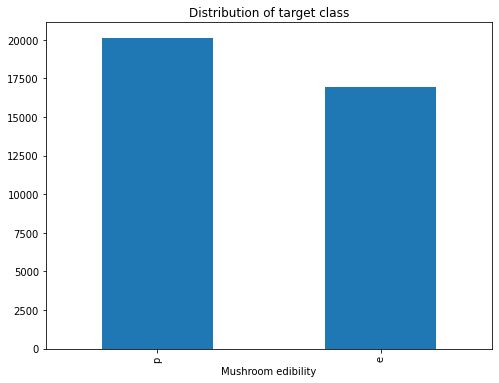

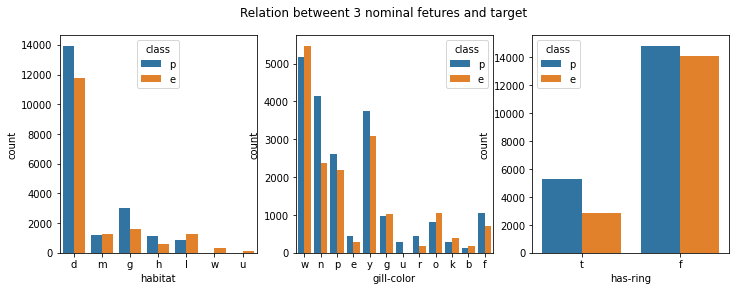

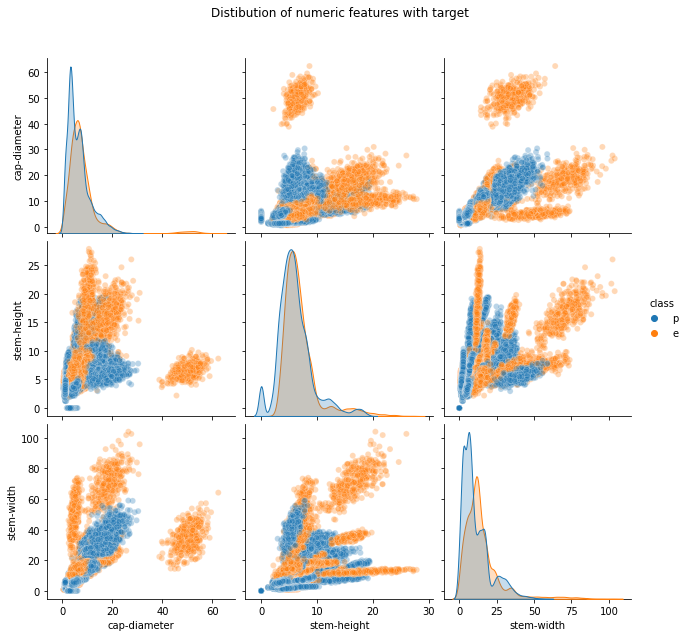

In [ ]:
# analyse data

# check the distibution of class feature
fig = plt.figure(figsize=(8,6))
df['class'].value_counts().plot(kind='bar')
plt.title('Distribution of target class')
plt.xlabel('Mushroom edibility')
#plt.savefig('dis_target.png')
plt.show()

# check the distribution between different habitats, season and cap-color 
fig, axs = plt.subplots(1, 3,figsize=(12,4))
sns.countplot(x='habitat', hue='class', data=df, ax=axs[0])
sns.countplot(x='gill-color', hue='class', data=df, ax=axs[1])
sns.countplot(x='has-ring', hue='class', data=df, ax=axs[2])
fig.suptitle('Relation betweent 3 nominal fetures and target')
#plt.savefig('nom_feture.png')
plt.show()

# distibution of the numerical features 
pp = sns.pairplot(df, vars=['cap-diameter', 'stem-height', 'stem-width'], 
            hue="class", height=3, aspect=1, plot_kws=dict(alpha=0.3) 
            )
pp.fig.suptitle("Distibution of numeric features with target")
pp.fig.subplots_adjust(top=.9)
#plt.savefig('num_features_dis.png')
plt.show()


In [ ]:
# # Mutual information feature selection
# # “Code adapted from: [https://machinelearningmastery.com/feature-selection-with-categorical-data/]”

# define function to split dataset to X and y
def load_data(df):
  X = df.iloc[:, :-1] 
  y = df.iloc[:, -1]
  return X, y

# define function to prepare input data
def prepare_input(X):
  categorical_cols = X.select_dtypes(include=['object']).columns
  numerical_cols = X.select_dtypes(include=['float64']).columns
  column_trans = make_column_transformer(
      (OrdinalEncoder(), categorical_cols),
      (MinMaxScaler(), numerical_cols),
      remainder='passthrough'
      )
  X = column_trans.fit_transform(X)
  #feature_names = column_trans.get_feature_names()
  return X #feature_names

# define function to prepare target data
# target label 0=e, 1=p
def prepare_target(y):
  le = preprocessing.LabelEncoder()
  y = le.fit_transform(y)
  label = list(le.classes_)
  return y, label

# define function to split data
def split_data(X, y, test_size, valid_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=0)
  return X_train, X_valid, X_test, y_train, y_valid, y_test

# define function for feature selection
def feature_selection(X_train, y_train, X_valid, feature_num):
  fs = SelectKBest(score_func=mutual_info_classif, k=feature_num)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_valid_fs = fs.transform(X_valid)
  mask = fs.get_support()
  new_features = df.iloc[:, :-1].columns[mask]
  print('Best', feature_num, 'features:', new_features)
  return X_train_fs, X_valid_fs, fs

# load data
X, y = load_data(df)
# prepare input data
X = prepare_input(X)
# prepare target
y, label = prepare_target(y)
# split into train, valid, test dataset
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X, y, 0.3, 0.3)
# feature selection
num_features = 4
X_train_fs, X_valid_fs, fs = feature_selection(X_train, y_train, X_valid, num_features)

# # scores for the features
# # we can check how each feature score,
# # but I don't know how to list all the features with their names 
# for i in range(len(fs.scores_)):
#   print('Feature %d: %f' % (i, fs.scores_[i]))


Best 4 features: Index(['cap-surface', 'gill-color', 'habitat', 'season'], dtype='object')


Logistic Regression Classifier accuracy: 57.39 
 Logistic Regression Classifier precision score: 58.05 
 Logistic Regression Classifier recall score: 76.85
Random Forest Classifier accuracy: 91.10 
 Random Forest Classifier precision score: 92.33 
 Random Forest Classifier recall score: 91.13
Decision Tree Classifier accuracy: 89.71 
 Decision Tree Classifier precision score: 90.55 
 Decision Tree Classifier recall score: 90.44


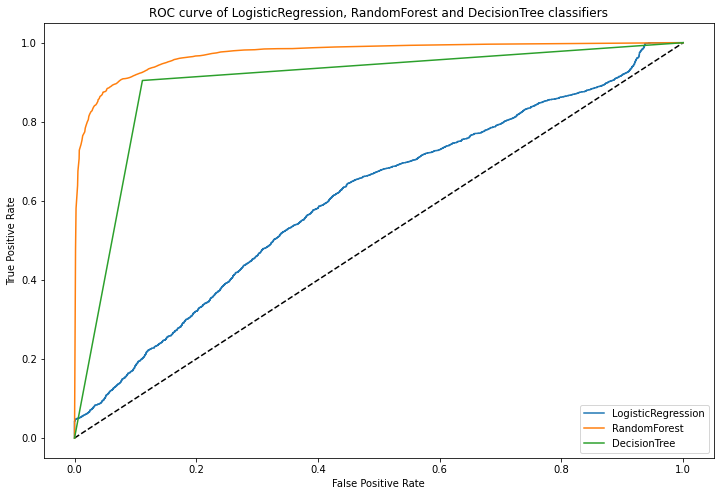

In [ ]:
# train LogisticRegression model
model_logit = LogisticRegression(solver='lbfgs')
model_logit.fit(X_train_fs, y_train)
# evaluate the model
ypred = model_logit.predict(X_valid_fs)
# evaluate predictions
accuracy = accuracy_score(y_valid, ypred)
precision = metrics.precision_score(y_valid, ypred)
recall = metrics.recall_score(y_valid, ypred)
print('Logistic Regression Classifier accuracy: %.2f \n' % (accuracy*100),
      'Logistic Regression Classifier precision score: %.2f \n' % (precision*100),
      'Logistic Regression Classifier recall score: %.2f' % (recall*100))


# train RandomForest model
model_RF = RandomForestClassifier(random_state=0)
model_RF.fit(X_train_fs, y_train)
# evaluate the model
ypred = model_RF.predict(X_valid_fs)
# evaluate predictions
accuracy = accuracy_score(y_valid, ypred)
precision = metrics.precision_score(y_valid, ypred)
recall = metrics.recall_score(y_valid, ypred)
print('Random Forest Classifier accuracy: %.2f \n' % (accuracy*100),
      'Random Forest Classifier precision score: %.2f \n' % (precision*100),
      'Random Forest Classifier recall score: %.2f' % (recall*100))

# train DecisionTree model
model_DT = DecisionTreeClassifier(random_state=0)
model_DT.fit(X_train_fs, y_train)
# evaluate the model
ypred = model_DT.predict(X_valid_fs)
# evaluate predictions
accuracy = accuracy_score(y_valid, ypred)
precision = metrics.precision_score(y_valid, ypred)
recall = metrics.recall_score(y_valid, ypred)
print('Decision Tree Classifier accuracy: %.2f \n' % (accuracy*100),
      'Decision Tree Classifier precision score: %.2f \n' % (precision*100),
      'Decision Tree Classifier recall score: %.2f' % (recall*100))

# ROC curve
y_pred_prob1 = model_logit.predict_proba(X_valid_fs)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_valid, y_pred_prob1)

y_pred_prob2 = model_RF.predict_proba(X_valid_fs)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_valid, y_pred_prob2)

y_pred_prob3 = model_DT.predict_proba(X_valid_fs)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_valid, y_pred_prob3)

plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "LogisticRegression")
plt.plot(fpr2, tpr2, label= "RandomForest")
plt.plot(fpr3, tpr3, label= "DecisionTree")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC curve of LogisticRegression, RandomForest and DecisionTree classifiers')
plt.savefig('ROC_compare.png')
plt.show()



In [ ]:
# tuning example

# randomforest tuning with selected 4 features ('cap-shape', 'gill-color', 'habitat', 'season')
# trying to tune the number of estimators(trees) to improve our model
n_estimators = 11
steps = 1
for n_estimators in range(1, n_estimators, steps):
 clf_RM = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
 clf_RM.fit(X_train_fs, y_train)
 ypred_RM = clf_RM.predict(X_valid_fs)
 print(f'The accuracy of RandomForest with {n_estimators} estimators is:{accuracy_score(y_valid, ypred_RM)}')


The accuracy of RandomForest with 1 estimators is:0.8851490236382322
The accuracy of RandomForest with 2 estimators is:0.8836073997944501
The accuracy of RandomForest with 3 estimators is:0.9010791366906474
The accuracy of RandomForest with 4 estimators is:0.9019784172661871
The accuracy of RandomForest with 5 estimators is:0.9058324768756424
The accuracy of RandomForest with 6 estimators is:0.9058324768756424
The accuracy of RandomForest with 7 estimators is:0.9073741007194245
The accuracy of RandomForest with 8 estimators is:0.9075025693730729
The accuracy of RandomForest with 9 estimators is:0.9060894141829393
The accuracy of RandomForest with 10 estimators is:0.9086587872559095


In [ ]:
# tuning parameters
# randomforest tuning with all features included
n_estimators = 11
steps = 1
for n_estimators in range(1, n_estimators, steps):
 clf_RM = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
 clf_RM.fit(X_train, y_train)
 ypred_RM = clf_RM.predict(X_valid)
 print(f'The accuracy of RandomForest with {n_estimators} estimators is:{accuracy_score(y_valid, ypred_RM)}')

The accuracy of RandomForest with 1 estimators is:0.9921634121274409
The accuracy of RandomForest with 2 estimators is:0.9903648509763617
The accuracy of RandomForest with 3 estimators is:0.9970452209660843
The accuracy of RandomForest with 4 estimators is:0.9978160328879754
The accuracy of RandomForest with 5 estimators is:0.9985868448098664
The accuracy of RandomForest with 6 estimators is:0.9984583761562179
The accuracy of RandomForest with 7 estimators is:0.9988437821171634
The accuracy of RandomForest with 8 estimators is:0.998972250770812
The accuracy of RandomForest with 9 estimators is:0.9992291880781089
The accuracy of RandomForest with 10 estimators is:0.998972250770812


In [ ]:
# evaluate performance
#X_test.shape test dataset still includes all features 
# prepare test data with same feature selection method
num_features = 4
X_train_fs, X_test_fs, fs = feature_selection(X_train, y_train, X_test, num_features)

# train a new model with 9 estimators
n_estimators = 9
clf_RM_ft = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
clf_RM_ft.fit(X_train_fs, y_train)

# use trained model to predict test dataset
ypred = clf_RM_ft.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, ypred)
precision = metrics.precision_score(y_test, ypred)
recall = metrics.recall_score(y_test, ypred)
print('Random Forest Classifier accuracy: %.2f \n' % (accuracy*100),
      'Random Forest Classifier precision score: %.2f \n' % (precision*100),
      'Random Forest Classifier recall score: %.2f' % (recall*100))

Best 4 features: Index(['gill-color', 'ring-type', 'habitat', 'season'], dtype='object')
Random Forest Classifier accuracy: 90.54 
 Random Forest Classifier precision score: 91.01 
 Random Forest Classifier recall score: 91.64


In [ ]:
# # check our final model 
# clf_RM_ft.classes_
# # there are 100 decision trees in our random forest 
# len(clf_RM_ft.estimators_)
# clf_RM_ft.n_features_in_
# # check our current parameters
# clf_RM_ft.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 9,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}